In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import  matplotlib.pyplot as plt 

from scipy.io import arff
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

RANDOM_STATE = 42
np.random.seed = 42

## Part A: Preprocessing and Initial Setup [10 points]

### 1. Data Loading [2]

In [11]:
data, meta = arff.loadarff('./Data/yeast.arff')
df = pd.DataFrame(data)

for col in df.select_dtypes([object]).columns:
    df[col] = df[col].str.decode('utf-8').astype(int)

X = df.iloc[:, :-14]
Y = df.iloc[:, -14:]

### 2. Dimensionality Check

In [12]:
print(f'Number of Features is {df.shape[1]}')
print(f'Number of Data Points is {df.shape[0]}')

Number of Features is 117
Number of Data Points is 2417


### 3. Label Selection for Visualization [5]

In [13]:
# Most frequent single-label combination
single_label_filter = Y[Y.sum(axis=1) == 1]
single_label_ranks = single_label_filter.apply(tuple, axis=1).value_counts()
top_single_class_1 = single_label_ranks.keys()[0]

# Most frequent multi-label combination
multi_label_ranks = Y.apply(tuple, axis=1).value_counts()
top_multi_class_1 = multi_label_ranks.keys()[0]
top_multi_class_2 = multi_label_ranks.keys()[1]

print(f'Most frequent single-label class is: {top_single_class_1}')
print(f'Most frequent multi-label class is: {top_multi_class_1}')
print(f'Second most frequent multi-label class is: {top_multi_class_2}')

color_target = pd.Series('Other', index=Y.index)

top_single_class_1_mask = (Y.apply(tuple, axis=1) == top_single_class_1)
color_target[top_single_class_1_mask] = ' '.join(str(t) for t in top_single_class_1)

top_multi_class_1_mask = (Y.apply(tuple, axis=1) == top_multi_class_1)
color_target[top_multi_class_1_mask] = ' '.join(str(t) for t in top_multi_class_1)

top_multi_class_2_mask = (Y.apply(tuple, axis=1) == top_multi_class_2)
color_target[top_multi_class_2_mask] = ' '.join(str(t) for t in top_multi_class_2)

print("\nNew target variable for coloring:")
print(color_target.value_counts())

Most frequent single-label class is: (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
Most frequent multi-label class is: (0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)
Second most frequent multi-label class is: (0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0)

New target variable for coloring:
Other                          1915
0 0 1 1 0 0 0 0 0 0 0 1 1 0     237
0 0 0 1 1 0 0 0 0 0 0 1 1 0     233
1 0 0 0 0 0 0 0 0 0 0 0 0 0      32
Name: count, dtype: int64


### 4. Scaling [3]

- Scaling is crucial before applying distance-based dimensionality reduction techniques because features with larger scales (e.g., age ranging from 20-80) will disproportionately dominate the distance calculations over features with smaller scales (e.g., a binary flag of 0 or 1).

- This imbalance tricks the algorithm into believing the larger-scale features are more important, leading to a distorted and biased representation of the data's true structure. Scaling ensures that all features contribute equally to the distance metric, resulting in a more accurate and meaningful low-dimensional embedding.

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\n--- Standardized Data ---")
print(X_scaled_df.describe().round(2))


--- Standardized Data ---
          Att1     Att2     Att3     Att4     Att5     Att6     Att7     Att8  \
count  2417.00  2417.00  2417.00  2417.00  2417.00  2417.00  2417.00  2417.00   
mean      0.00    -0.00    -0.00     0.00    -0.00    -0.00    -0.00     0.00   
std       1.00     1.00     1.00     1.00     1.00     1.00     1.00     1.00   
min      -3.82    -4.82    -3.47    -4.83    -3.80    -5.24    -3.30    -6.15   
25%      -0.56    -0.60    -0.59    -0.59    -0.62    -0.62    -0.61    -0.65   
50%       0.03    -0.03     0.03    -0.00     0.04    -0.00     0.05     0.01   
75%       0.58     0.50     0.63     0.56     0.67     0.61     0.70     0.63   
max       5.33     6.28     3.62     5.87     3.16     3.46     3.61     4.69   

          Att9    Att10  ...    Att94    Att95    Att96    Att97    Att98  \
count  2417.00  2417.00  ...  2417.00  2417.00  2417.00  2417.00  2417.00   
mean      0.00     0.00  ...    -0.00    -0.00    -0.00    -0.00    -0.00   
std       1.

## Part B: t-SNE and Veracity Inspection [20 points]

### 1. t-SNE Implementation [5]

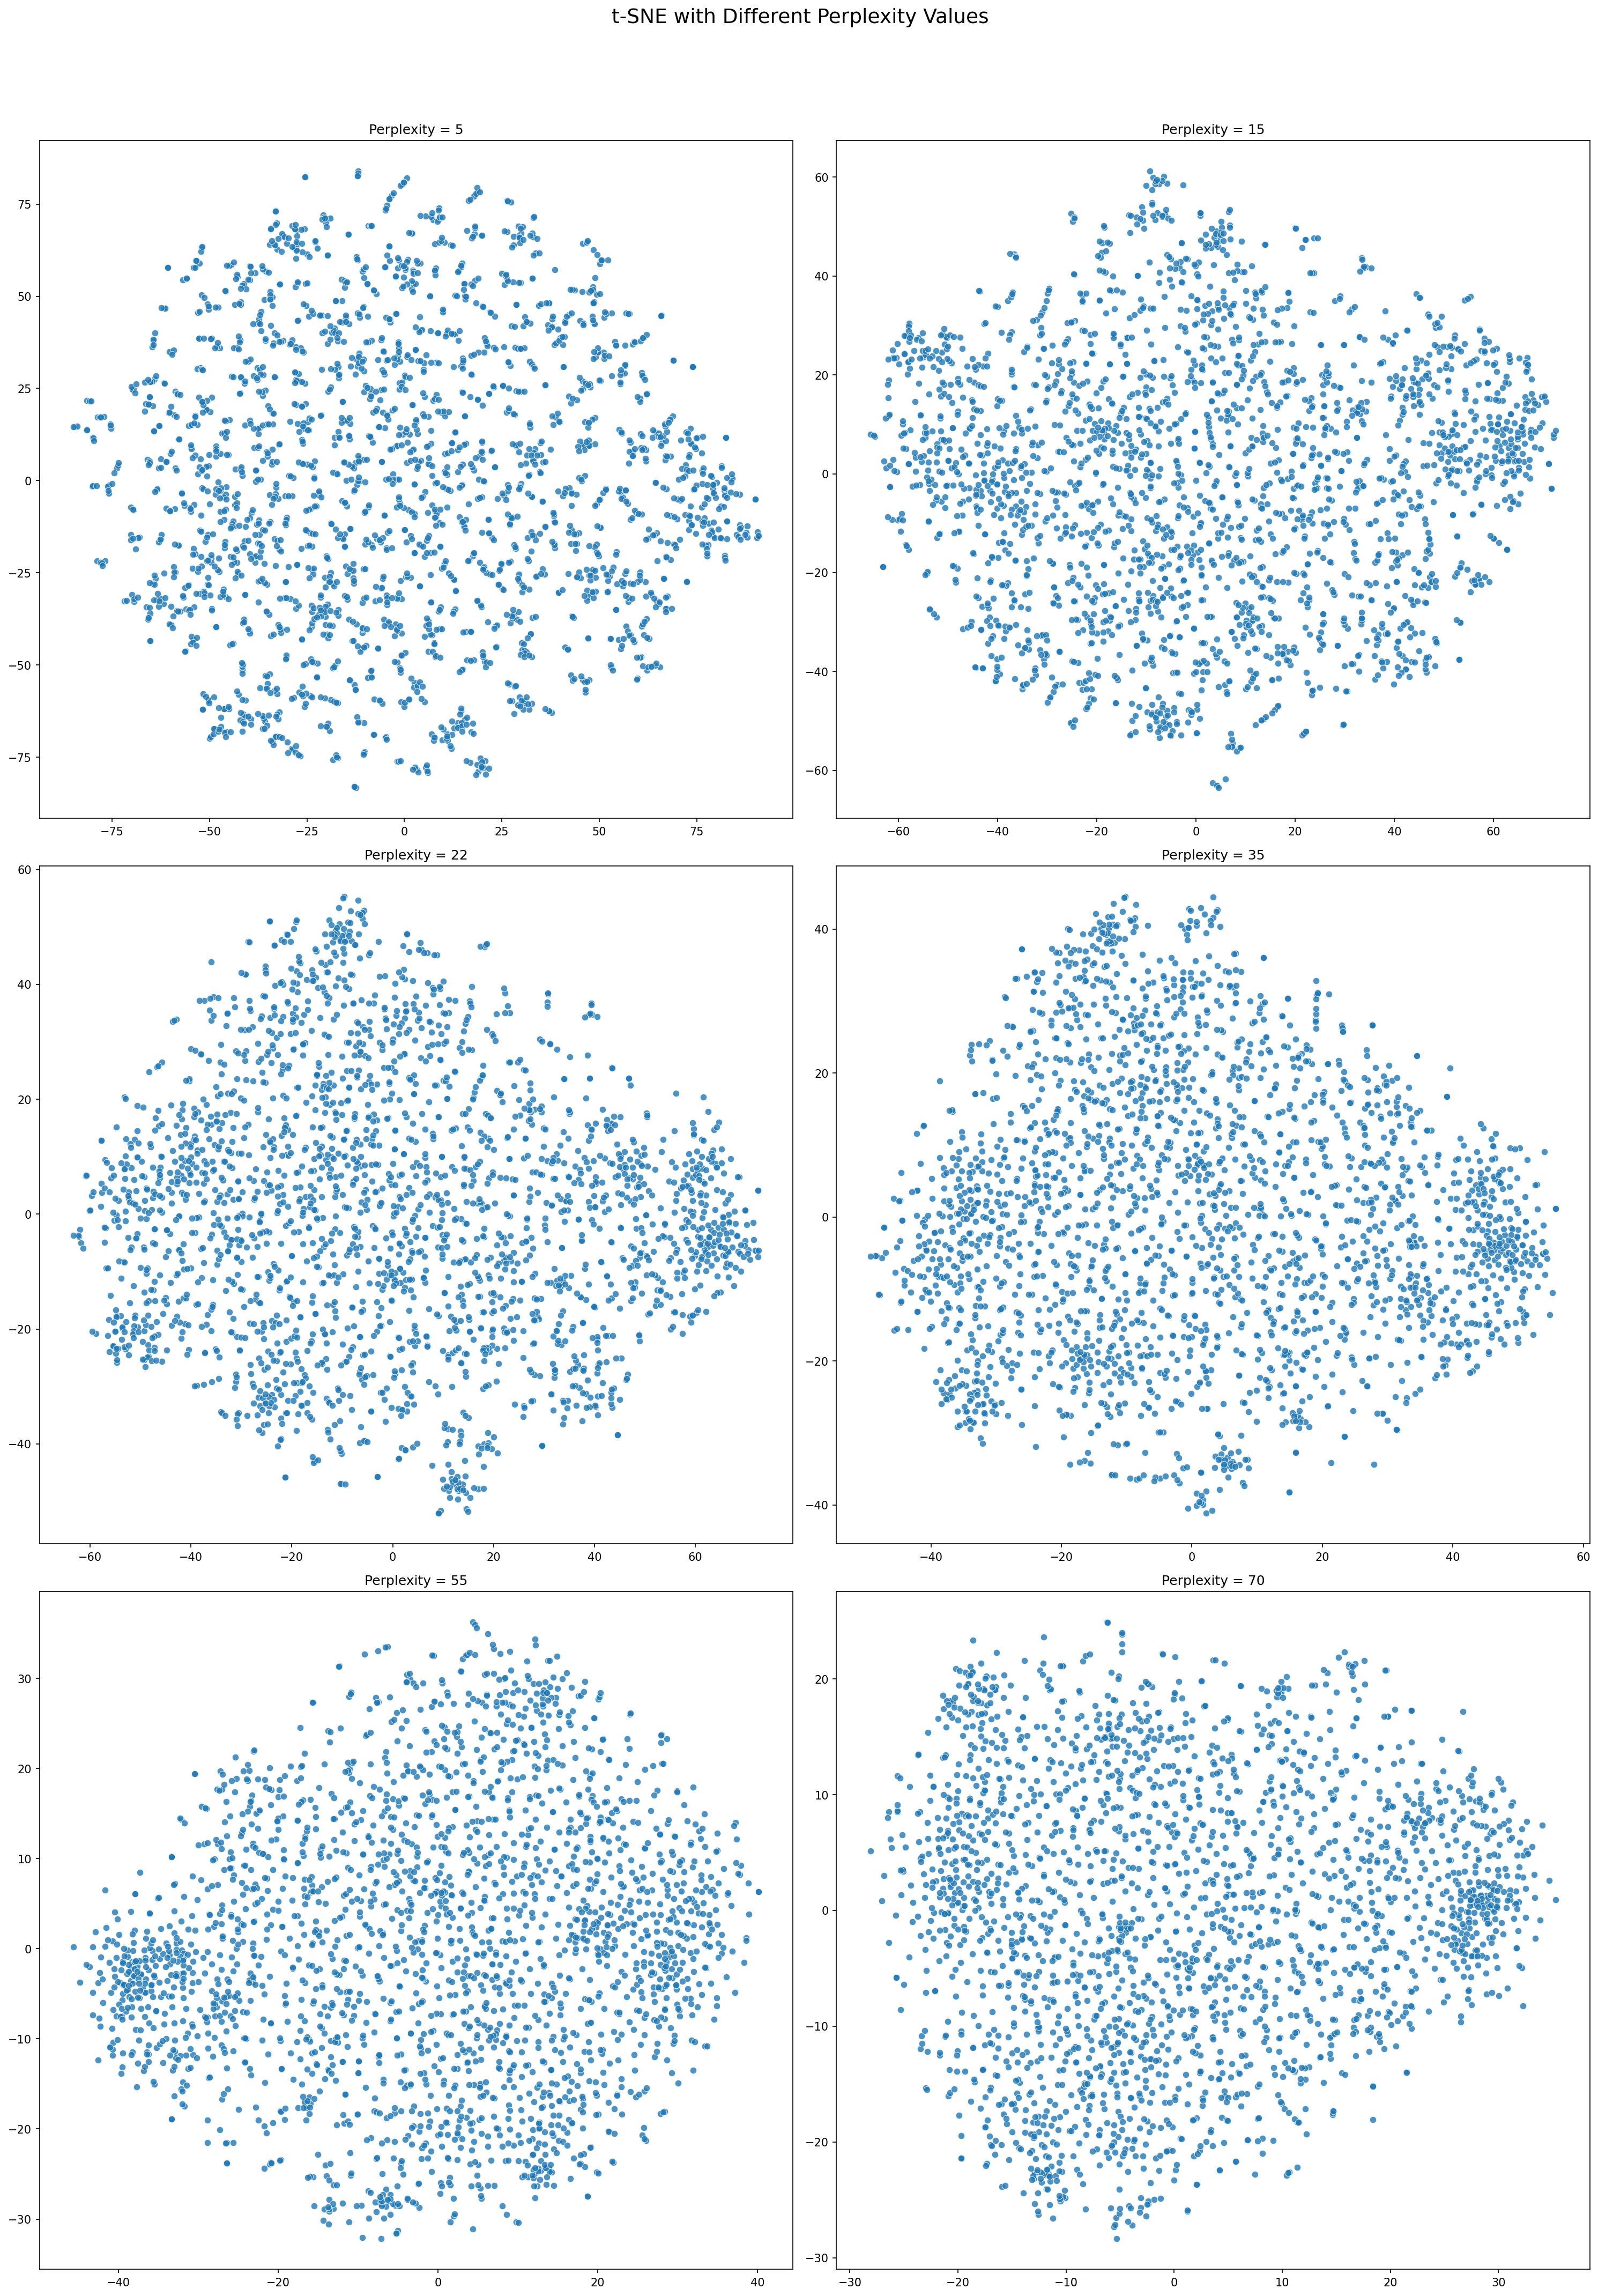

In [21]:
perplexities = [5, 15, 22, 35, 55, 70]
fig, axes = plt.subplots(3, 2, figsize=(20, 30), dpi=150)
fig.suptitle('t-SNE with Different Perplexity Values', fontsize=18)

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=RANDOM_STATE, init='pca', learning_rate='auto')
    X_tsne = tsne.fit_transform(X_scaled)

    tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
    tsne_df['label'] = color_target.values
    
    ax = axes[i//2, i%2]
    sns.scatterplot(
            x='TSNE1', y='TSNE2',
            # hue='label',
            # palette=sns.color_palette("hls", n_colors=tsne_df['label'].nunique()),
            data=tsne_df,
            legend="full",
            alpha=0.8,
            ax=ax
        )

    ax.set_title(f'Perplexity = {perplexity}')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

After observing the plots, the best choice for perplexity can be justified as follows:

- **Perplexity = 5**: This value is too low. The plot shows the data being broken into many small, disconnected clumps. It's focusing too much on the immediate local neighbors and fails to capture the broader, more meaningful global structure. The overall arrangement feels random and noisy.

- **Perplexity = 35 or 70**: This value is quite high. The clusters have started to merge, and the distinction between them is becoming less clear. While it shows some global structure, it might be smoothing over important local details and forcing distinct groups to blend together.

- **Perplexity = 22 (Final Choice)**: This value provides the best balance. It reveals several well-defined, reasonably separated clusters corresponding to our target labels. It successfully captures the underlying groupings in the data without either shattering them into tiny pieces (like perplexity 5) or blurring them together (like perplexity 35). This visualization is the most informative for understanding the relationships between the data points.

Therefore, a **perplexity of 22** is the most suitable choice as it offers the clearest and most stable representation of the data's inherent clusters.

### 2. Visualization [5]

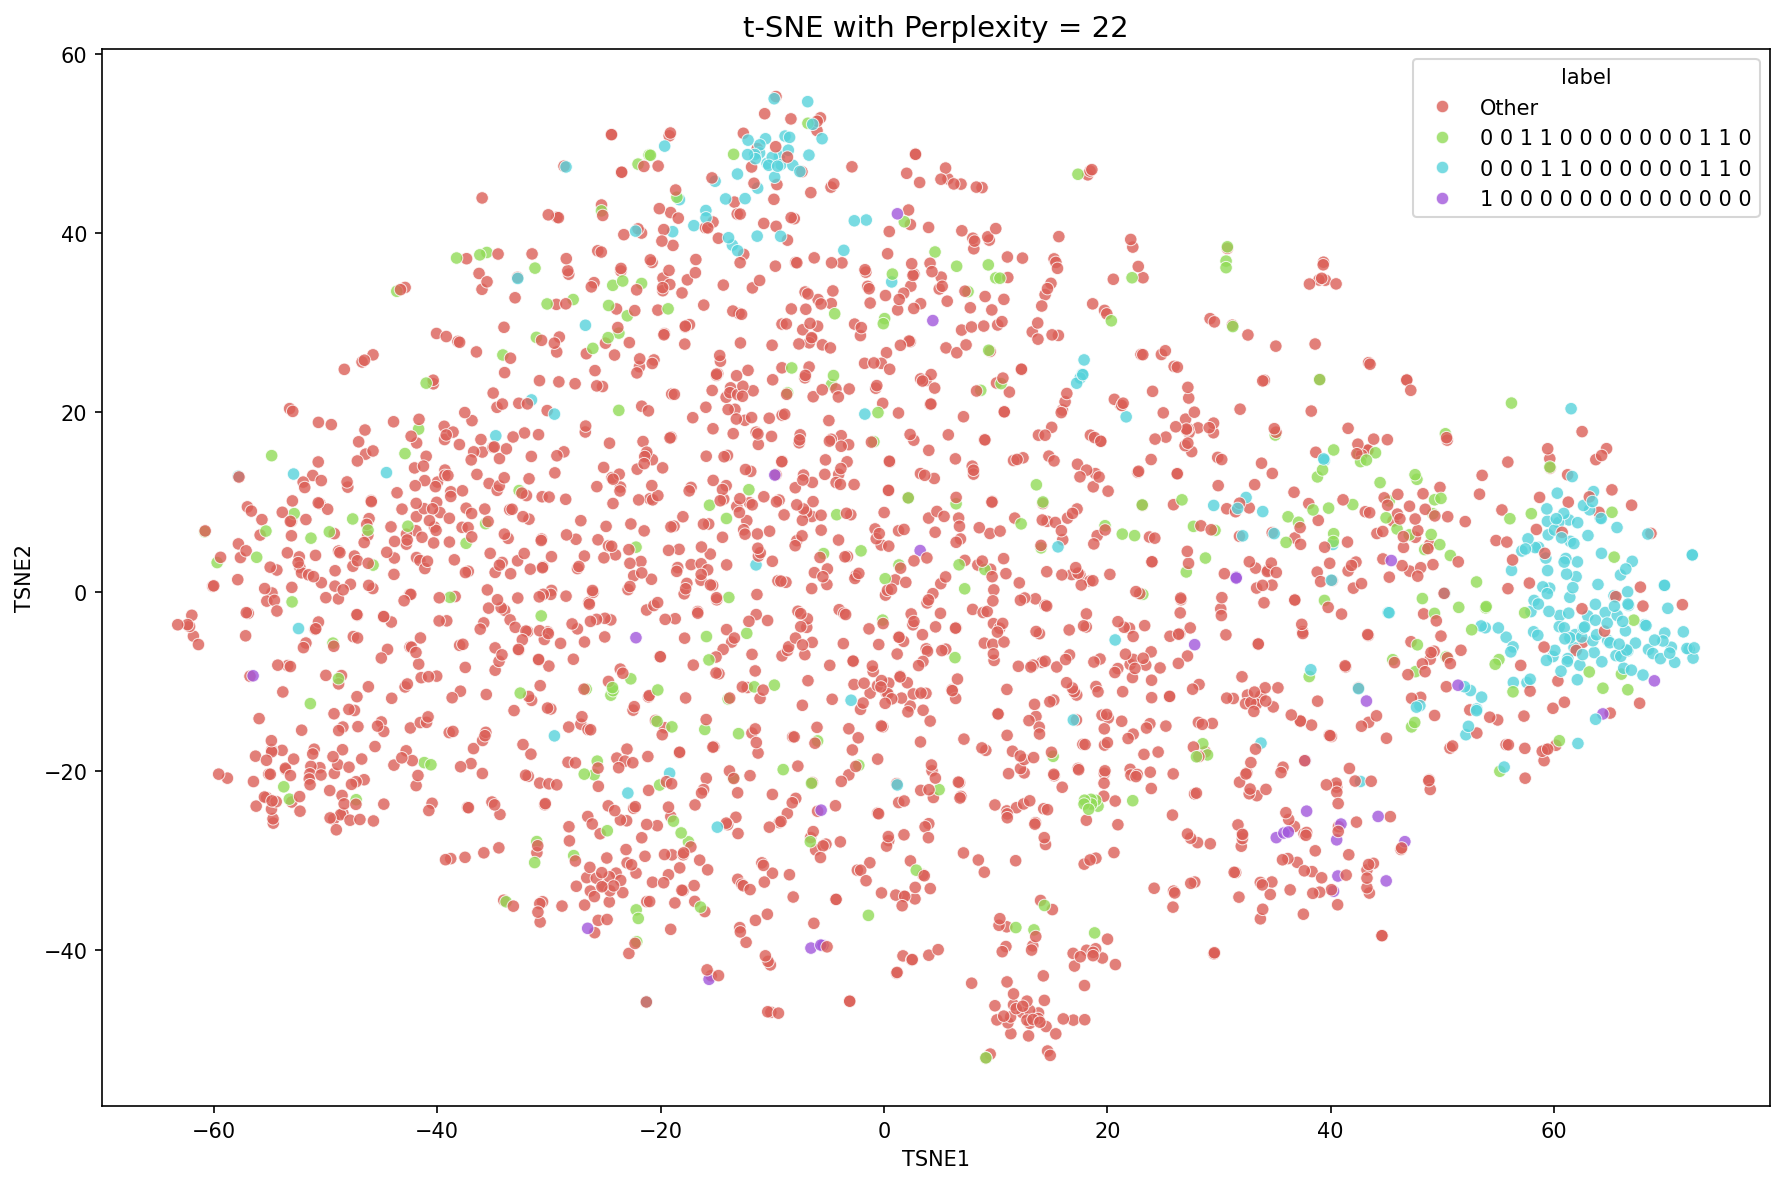

In [16]:
# Assuming X_scaled, RANDOM_STATE, and color_target are already defined
final_perplexity = 22

# Create TSNE embedding
tsne = TSNE(
    n_components=2, 
    perplexity=final_perplexity, 
    random_state=RANDOM_STATE, 
    init='pca', 
    learning_rate='auto'
)
X_tsne = tsne.fit_transform(X_scaled)

# Create dataframe for plotting
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = color_target.values

# Plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=150)
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue='label',
    palette=sns.color_palette("hls", n_colors=tsne_df['label'].nunique()),
    data=tsne_df,
    legend="full",
    alpha=0.8,
    ax=ax
)

ax.set_title(f't-SNE with Perplexity = {final_perplexity}', fontsize=14)
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
plt.tight_layout()
plt.show()


### 3. Veracity Inspection [10]



- Ok

## Part C: Isomap and Manifold Learning [20 points]

### 1. Isomap Implementation [5]

- Isomap (Isometric Mapping) and t-SNE are both dimensionality reduction techniques, but their core difference lies in what aspect of the data's structure they prioritize preserving.

- **t-SNE** is primarily concerned with preserving the local structure. It focuses on ensuring that points that are close neighbors in the high-dimensional space remain close neighbors in the low-dimensional map. It excels at revealing the fine-grained cluster structure within the data but often distorts the global geometry, meaning the distances and orientations between distant clusters in the final plot may not be meaningful.

- **Isomap**, on the other hand, aims to preserve the global structure. It calculates the "geodesic distance" between all pairs of points—the shortest path along the curved manifold of the data, as if "walking" from one point to another without leaving the data cloud. By preserving these more accurate long-range distances, Isomap creates a low-dimensional embedding that better reflects the overall shape and layout of the entire dataset, though it might sometimes sacrifice the finer details of local neighborhoods.

In [23]:
# 1. Initialize and apply Isomap
# We'll use n_neighbors=30, similar to our chosen t-SNE perplexity, as a starting point.
isomap = Isomap(n_components=2, n_neighbors=30)
X_isomap = isomap.fit_transform(X_scaled)

# 2. Create a DataFrame for plotting
isomap_df = pd.DataFrame(data=X_isomap, columns=['Isomap1', 'Isomap2'])
isomap_df['label'] = color_target.values

### 2. Visualization [5]

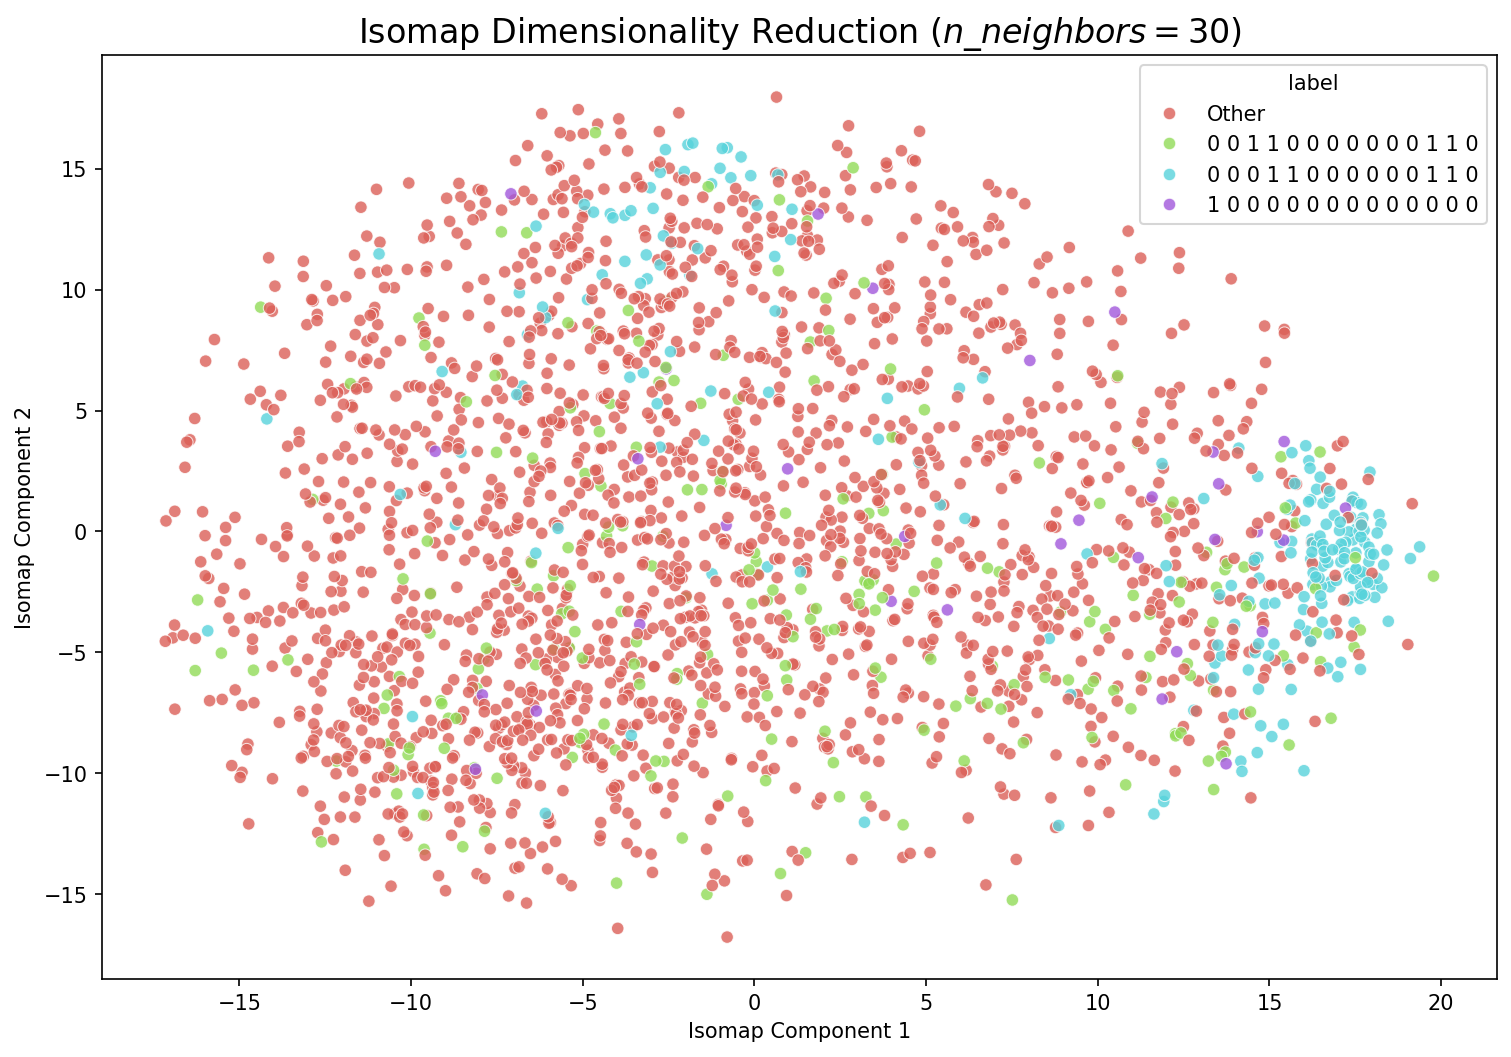

In [27]:
# 3. Plot the results
plt.figure(figsize=(12, 8), dpi=150)
sns.scatterplot(
    x='Isomap1', y='Isomap2',
    hue='label',
    palette=sns.color_palette("hls", n_colors=isomap_df['label'].nunique()),
    data=isomap_df,
    legend="full",
    alpha=0.8
)
plt.title('Isomap Dimensionality Reduction ($n\_neighbors=30$)', fontsize=16)
plt.xlabel('Isomap Component 1')
plt.ylabel('Isomap Component 2')
plt.show()

### 3. Comparision and Curvature [10]

- **Isomap vs. t-SNE for Global Structure**: Isomap is better at revealing the global structure. While t-SNE excels at creating tight, visually distinct local clusters, Isomap preserves geodesic distances, providing a more faithful representation of the data's overall shape and the long-range relationships between different clusters.

- **The Data Manifold**: The data manifold is a concept suggesting that high-dimensional data often lies on a lower-dimensional, curved surface embedded within the higher-dimensional space. Think of a rolled-up sheet of paper in a 3D box; the 2D surface of the paper is the manifold.

- **Manifold Curvature from Isomap**: The Isomap plot, by "unrolling" the data, can suggest a curved manifold if it reveals structures like arcs or elongated shapes that t-SNE might break into separate clusters. A plot showing clear, arching patterns indicates a more curved manifold.

- **Manifold Complexity and Classification**: A highly curved or complex manifold makes classification more difficult. Linear classifiers (like logistic regression) will fail because they cannot draw simple straight lines to separate the classes. More complex, non-linear models are required to learn the intricate boundaries on the curved surface.